# Assignment 02

- Name: Ran Arino
- Student ID: 153073200
- Email: rarino@myseneca.ca
- Course: Machine Learning
- Course ID: BDA500NAA.05380.2237
- Professor: Dr. Amir Moslemi

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
# load dataset
from mat4py import loadmat 
data = loadmat('CatDog.mat')

In [3]:
# get the feature matrix
X = np.array(data['X']).T
print(f"Observations: {X.shape[0]}, Features: {X.shape[1]}")

# get the target vector
y = np.array(data['G'])
print(f'Dimension: {y.shape}')

Observations: 242, Features: 4096
Dimension: (242,)


In [46]:
# normalizing data
X_min, X_max = X.min(), X.max()
X_norm = (X - X_min) / (X_max - X_min)
# reshape data
X_norm_ = X_norm.reshape(242, 64, 64, 1)
# converting from gray scale to the RGB scale
X_norm_ = np.repeat(X_norm_, 3, axis=-1)
# transpose the data
trans_X_norm_ = np.transpose(X_norm_, (0, 2, 1, 3))
# Flip along the second axis
comp_X = np.flip(trans_X_norm_, axis=2)

print(comp_X.shape)

(242, 64, 64, 3)


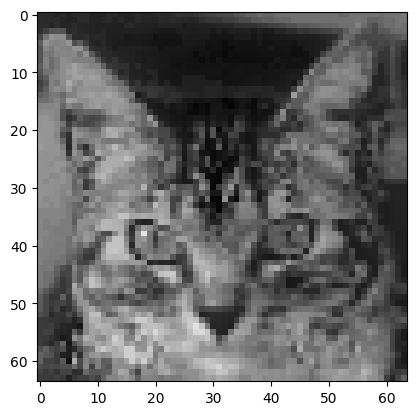

In [51]:
# show result
plt.imshow(comp_X[0])

In [63]:
# apply preprocessing data, then change the ready-to-fit the model
X_ready = preprocess_input(comp_X)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=0)

print('Training: ')
print(f'X: {X_train.shape}, y: {y_train.shape}')
print('Test: ')
print(f'X: {X_test.shape}, y: {y_test.shape}')

Training: 
X: (169, 64, 64, 3), y: (169,)
Test: 
X: (73, 64, 64, 3), y: (73,)


In [60]:
# loading VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(64, 64, 3)))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# show summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
base_model.fit()

In [68]:
# create new model
model = Sequential()
# add VGG16 model
model.add(base_model)

# new layers for binary classification
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               262272    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 14985281 (57.16 MB)
Trainable params: 14985281 (57.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
11/11 [==============================] - 12s 830ms/step - loss: 0.6933 - accuracy: 0.4438 - val_loss: 0.6931 - val_accuracy: 0.5342
Epoch 2/10
11/11 [==============================] - 9s 802ms/step - loss: 0.6932 - accuracy: 0.4675 - val_loss: 0.6931 - val_accuracy: 0.5342
Epoch 3/10
11/11 [==============================] - 11s 1s/step - loss: 0.6932 - accuracy: 0.4852 - val_loss: 0.6932 - val_accuracy: 0.4658
Epoch 4/10
11/11 [==============================] - 15s 1s/step - loss: 0.6932 - accuracy: 0.5148 - val_loss: 0.6932 - val_accuracy: 0.4658
Epoch 5/10
11/11 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.5148 - val_loss: 0.6933 - val_accuracy: 0.4658
Epoch 6/10
11/11 [==============================] - 14s 1s/step - loss: 0.6931 - accuracy: 0.5148 - val_loss: 0.6933 - val_accuracy: 0.4658
Epoch 7/10
11/11 [==============================] - 12s 1s/step - loss: 0.6932 - accuracy: 0.5148 - val_loss: 0.6934 - val_accuracy: 0.4658
Epoch 8/10
11/1